In [1]:
%cd ..

/juicier/scr100/scr/pangwei/influence_release


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import math
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing
import scipy
import scipy.linalg as slin
import scipy.sparse.linalg as sparselin
import scipy.sparse as sparse

sns.set(color_codes=True)

from load_animals import load_animals
from influence.image_utils import plot_flat_colorimage, plot_flat_colorgrad

Using TensorFlow backend.


In [3]:
num_classes = 2
num_train_ex_per_class = 900
num_test_ex_per_class = 300

model_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
image_data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
    classes=['dog', 'fish'])

Loading animals from disk...


In [4]:
X_train = image_data_sets.train.x
X_test = image_data_sets.test.x
Y_train = image_data_sets.train.labels * 2 - 1
Y_test = image_data_sets.test.labels * 2 - 1

In [5]:
f = np.load('output/rbf_results.npz')
    
test_idx = f['test_idx']
distances = f['distances']
flipped_idx = f['flipped_idx']
rbf_margins_test = f['rbf_margins_test']
rbf_margins_train = f['rbf_margins_train']
inception_Y_pred_correct = f['inception_Y_pred_correct']
rbf_predicted_loss_diffs = f['rbf_predicted_loss_diffs']
inception_predicted_loss_diffs = f['inception_predicted_loss_diffs']

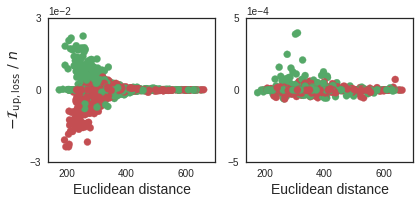

In [6]:
sns.set_style('white')
fontsize=14

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(6, 3))

num_train = len(flipped_idx)
color_vec = np.array(['g'] * num_train)
color_vec[flipped_idx] = 'r'
color_vec = list(color_vec)

axs[0].scatter(distances, rbf_predicted_loss_diffs, color=color_vec)
axs[0].set_ylim(-0.03, 0.03)
axs[0].set_yticks((-0.03, 0, 0.03))
axs[0].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[0].set_xlabel('Euclidean distance', fontsize=fontsize)
axs[0].set_ylabel('$-\mathcal{I}_\mathrm{up, loss} \ /\ n$', fontsize=fontsize)

axs[1].scatter(distances, inception_predicted_loss_diffs, color=color_vec)
axs[1].set_ylim(-0.0005, 0.0005)
axs[1].set_yticks((-0.0005, 0, 0.0005))
axs[1].ticklabel_format(style='sci', scilimits=(0,0), axis='y')
axs[1].set_xlabel('Euclidean distance', fontsize=fontsize)

plt.tight_layout()
# plt.savefig('figs/fig-rbf-dist.png', dpi=600, bbox_inches='tight')

Test image:
1.0 0.990029 0.996598780155


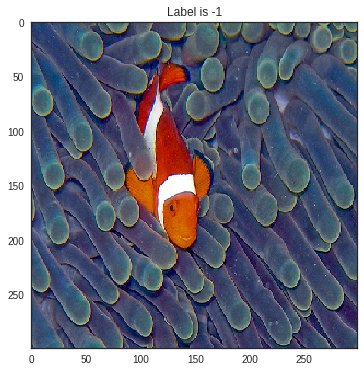

Top from RBF:
1103 1.0 194.052 0.280523 0.0181634648641
1700 1.0 231.38 0.205813 0.0183315192329
286 1.0 206.636 0.68004 0.0204726939731
765 1.0 214.331 -0.320072 0.0215222994486
925 1.0 254.57 0.448963 0.0223644129435


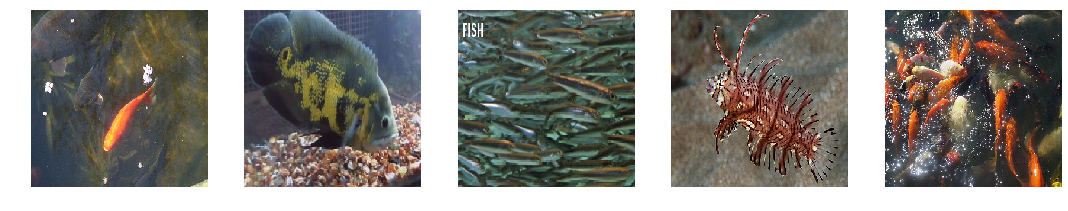

Top from Inception:
1250 1.0 246.74 0.00015671680371
550 1.0 325.733 0.000206479612324
1723 1.0 273.849 0.00024590689275
203 1.0 301.682 0.000386038488812
1380 1.0 308.696 0.000394601954354


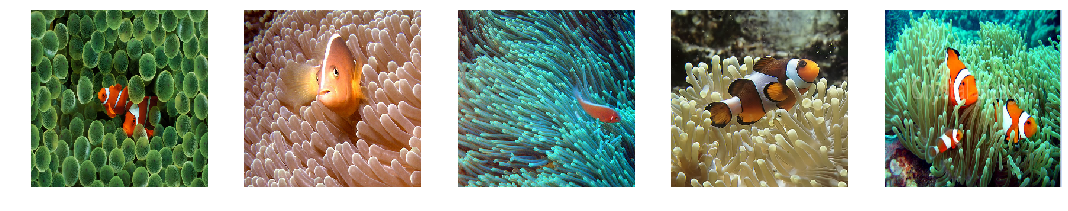

Dogs:
19 526 -1.0 637.901 7.16602967845e-05
23 664 -1.0 350.888 5.98945468664e-05
25 607 -1.0 313.919 5.84903152453e-05
26 786 -1.0 346.762 5.57758162419e-05
27 1623 -1.0 398.698 5.4756709271e-05


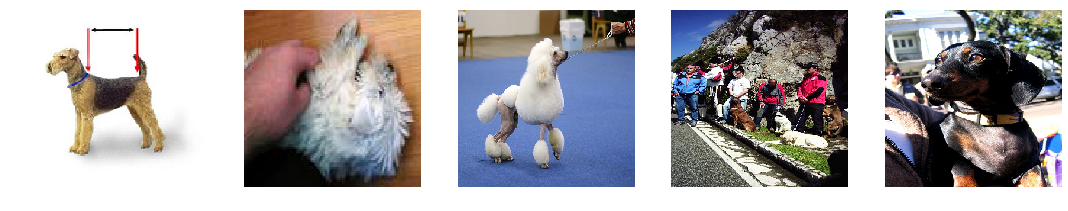

In [10]:
print('Test image:')
print(Y_test[test_idx], rbf_margins_test[test_idx], inception_Y_pred_correct[test_idx])
plot_flat_colorimage((X_test[test_idx, :] + 1) / 2, 0, side=299)
    
print('Top from RBF:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(rbf_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], rbf_margins_train[train_idx], rbf_predicted_loss_diffs[train_idx])
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('figs/fig-rbf-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Top from Inception:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for counter, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[-5:]):
    print(train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
    x_train = X_train[train_idx, :]
    axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
    axs[counter].axis('off')
plt.tight_layout()
# plt.savefig('figs/fig-inception-fishes.png', dpi=600, bbox_inches='tight')
plt.show()

print('Dogs:')
fig, axs = plt.subplots(1, 5, figsize=(15,3))
counter = 4
for i, train_idx in enumerate(np.argsort(inception_predicted_loss_diffs)[:-50:-1]):
    if Y_train[train_idx] == -1.0:
        print(i, train_idx, Y_train[train_idx], distances[train_idx], inception_predicted_loss_diffs[train_idx])    
        x_train = X_train[train_idx, :]
        axs[counter].imshow((np.reshape(x_train, [299, 299, 3]) + 1) / 2, interpolation='none')  
        axs[counter].axis('off')
        counter -= 1
    if counter == -1:
        break
plt.tight_layout()
# plt.savefig('figs/fig-inception-dogs.png', dpi=600, bbox_inches='tight')
plt.show()